## Evaluation

This script will evaluate extensively which MRI modalities add the most value for glioma classification with XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from collections import Counter
import ast

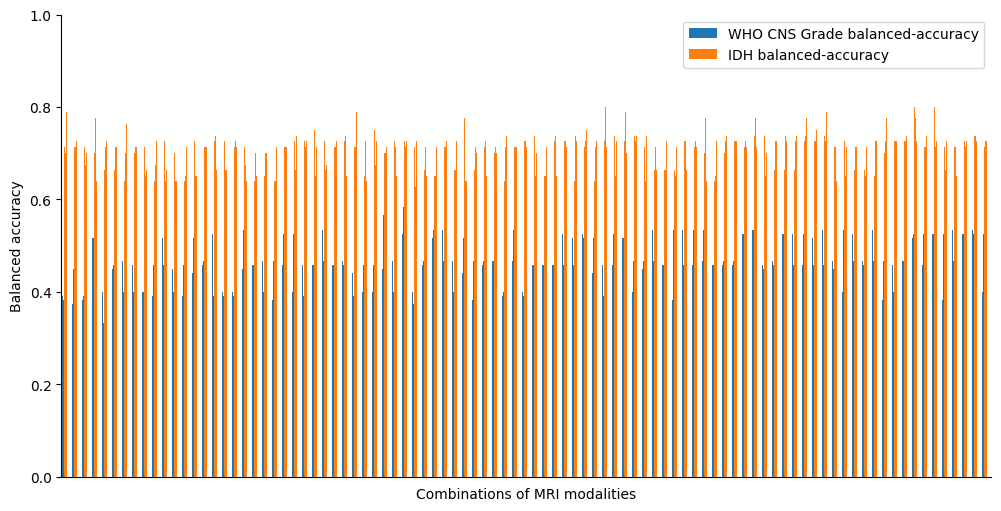

In [39]:
def visualize_comparison(results_df, ROI):
    # Select only columns with '_balanced-accuracy' in their names
    performance_columns = [col for col in results_df.columns if 'balanced-accuracy' in col]
    results_df = results_df[['Acquisition'] + performance_columns]

    # Plot the data
    ax = results_df.plot.bar(rot=0, figsize=(12, 6), x='Acquisition')
    plt.ylim(0, 1)
    plt.ylabel("Balanced accuracy")
    plt.xlabel("Combinations of MRI modalities")
    #plt.title(f"(Filter = {Filter})")
    
    # Turn off the x-axis ticks and labels
    ax.axes.get_xaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the figure
    fig = ax.get_figure()
    fig.savefig(f"/Users/Gabriel/Desktop/bestOverall{ROI}.png", dpi=300)

# Import data 
ROI = 'brain'
results_df = pd.read_csv('/Users/Gabriel/MSc_Dissertation/pyRadiomics/Model_performance/' + ROI + '_XGBoost_evaluation.csv')

# Call the function
visualize_comparison(results_df, ROI)


### Table: Best modalities for overall prediction

In [15]:
# Import data 
ROI = ['roi1', 'roi4', 'roi2', 'whole_tumour', 'brain']
ROI_names = ['Necrotic core', 'Enhancing region', 'Non-enhancing region', 'Whole tumour', 'Brain']

dataframes = {}
for roi in ROI:
    df = pd.read_csv(f'/Users/Gabriel/MSc_Dissertation/pyRadiomics/Model_performance/{roi}_XGBoost_evaluation.csv')
    df['sum'] = df['WHO CNS Grade balanced-accuracy'] + df['IDH balanced-accuracy']
    dataframes[roi] = df

# Create a mapping from the original names to the new names
name_mapping = dict(zip(ROI, ROI_names))

# Calculate mean of 'sum' column for each DataFrame
average_sums = {name_mapping[roi]: df['sum'].mean() for roi, df in dataframes.items()}

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
largest = dataframes['whole_tumour'].nlargest(3, 'sum')
smallest = dataframes['whole_tumour'].nsmallest(20, 'sum')

df_sorted_all = dataframes['whole_tumour'].sort_values(by='sum', ascending=False)

#largest


/Users/Gabriel/opt/anaconda3/envs/py3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


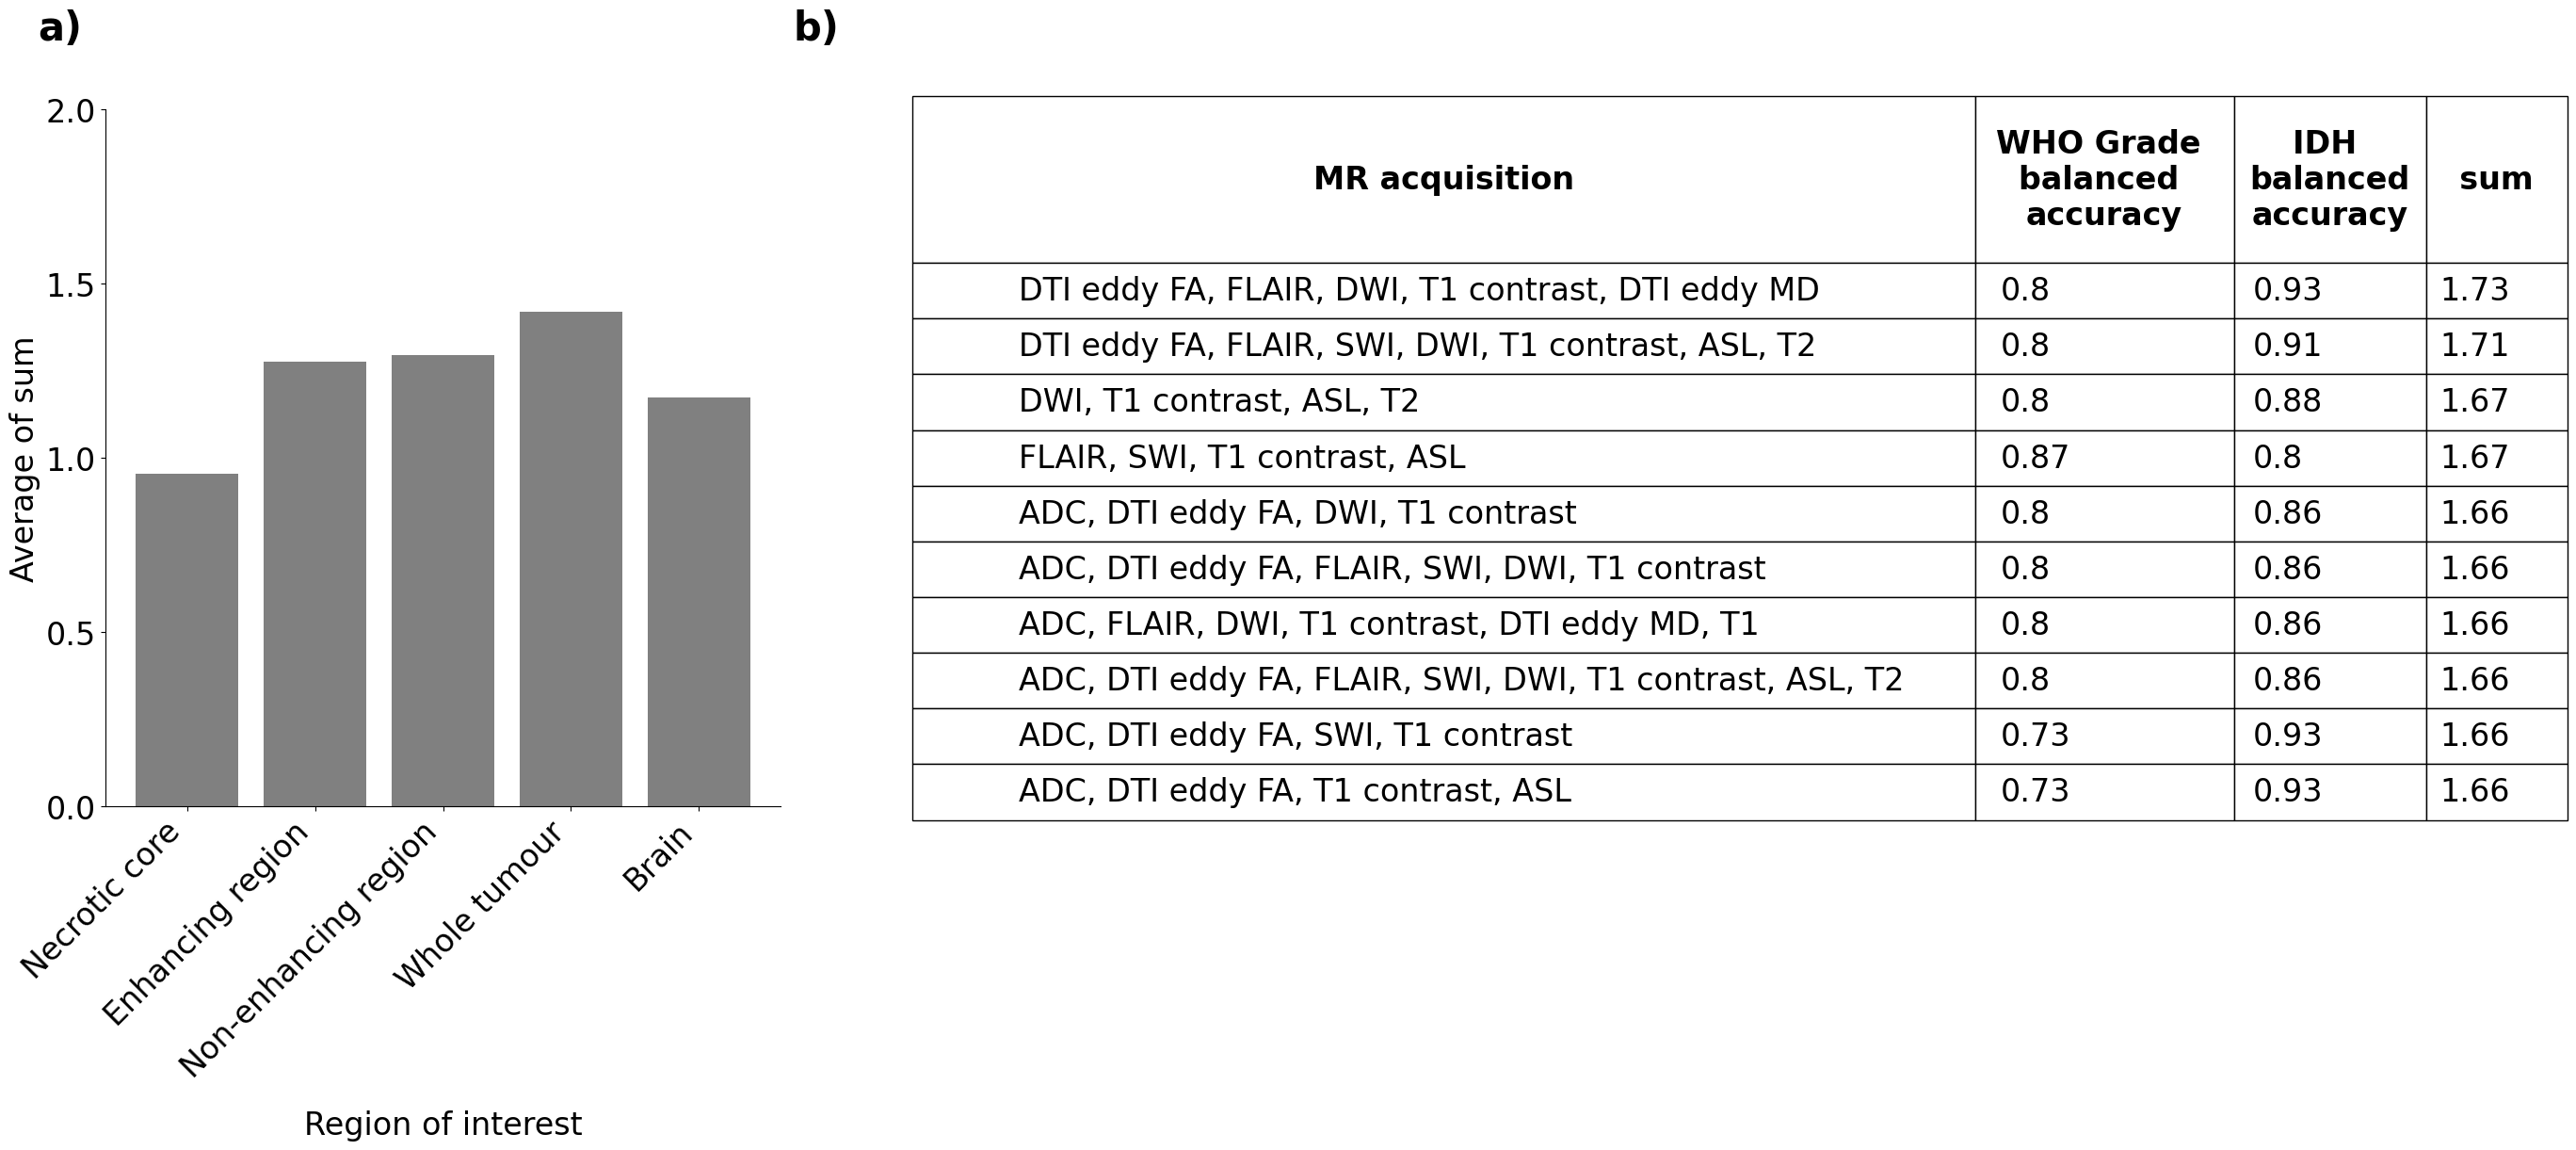

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fontsize = 24
ABsize = 30

# Increase default font size
plt.rcParams.update({'font.size': fontsize})

# Create a figure with two subplots, one of which is twice as wide as the other
fig = plt.figure(figsize=(30, 13))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.1])  # Here, you create 3 subplots, the second one is twice as wide as the first one, and the last one is left empty to act as a spacer.

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Bar Plot
ax1.bar(average_sums.keys(), average_sums.values(), color = 'grey')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Region of interest', labelpad = 20)
ax1.set_ylabel('Average of sum')
ax1.set_ylim(0,2)
ax1.set_yticks(np.arange(0, 2.5, 0.5))  # Set y-axis ticks
ax1.text(-0.1, 1.1, 'a)', transform=ax1.transAxes, size=ABsize, weight='bold')
ax1.set_xticklabels(average_sums.keys(), rotation=45, ha = 'right') # Rotate x-axis labels

# Table of best modalities
# Your dataframe
df_to_save = dataframes['whole_tumour'].nlargest(10, 'sum')

# Round to 2 decimal places
df_to_save = df_to_save.round(2)

# Remove parentheses and single quotes from the 'Acquisition' column
df_to_save['Acquisition'] = df_to_save['Acquisition'].str.replace(r"[()']", '')
df_to_save['Acquisition'] = df_to_save['Acquisition'].str.replace(r"[_]", ' ')

# Rename 'WHO CNS Grade balanced-accuracy' column
df_to_save = df_to_save.rename(columns={'WHO CNS Grade balanced-accuracy': 'WHO Grade \nbalanced \naccuracy'})
df_to_save = df_to_save.rename(columns={'IDH balanced-accuracy': 'IDH \nbalanced\naccuracy'})
df_to_save = df_to_save.rename(columns={'sum': '  sum  '})
df_to_save = df_to_save.rename(columns={'Acquisition': 'MR acquisition'})

# Hide axes for table
ax2.axis('off')

# Make a table and add it to the figure
table = ax2.table(cellText=df_to_save.values, 
                  colLabels=df_to_save.columns, 
                  cellLoc = 'left', 
                  loc='center')

# Increase the width of the cells of the first column
table.auto_set_column_width(col=list(range(len(df_to_save.columns))))
table[0, 0].set_width(2*table[0, 0].get_width())

table.auto_set_font_size(False)
table.set_fontsize(fontsize)

# Make the headers bold
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_fontsize(10)
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

# Increase the height of the header row only
for i in range(len(df_to_save.columns)):
    cell = table[0, i]
    cell.set_height(3*cell.get_height())
    
for (row, col), cell in table.get_celld().items():
    cell.set_height(1.2*cell.get_height())

table.scale(4.0, 4.0)

ax2.text(-0.2, 1.1, 'b)', transform=ax2.transAxes, size=ABsize, weight='bold')


plt.tight_layout()
plt.savefig('/Users/Gabriel/Desktop/Figure_larger2.png', dpi=300)
plt.show()


## Frequency of Modalities at top 10

In [14]:
# Assuming df_sorted_all is your DataFrame and already sorted
top_10 = df_sorted_all.nlargest(10, 'sum')

# Convert string to tuple and flatten the list of acquisitions
all_acquisitions = [acquisition for sublist in top_10['Acquisition'].apply(ast.literal_eval) for acquisition in sublist]

# Count the frequency of each acquisition
counter = Counter(all_acquisitions)

# Sort by frequency in descending order and print out
for acquisition, freq in counter.most_common():
    print(f"{acquisition}: {freq}")

T1_contrast: 10
DWI: 8
DTI_eddy_FA: 6
FLAIR: 6
SWI: 6
ADC: 6
ASL: 5
T2: 3
DTI_eddy_MD: 2
T1: 1


## Distribution of top Modalities across performances

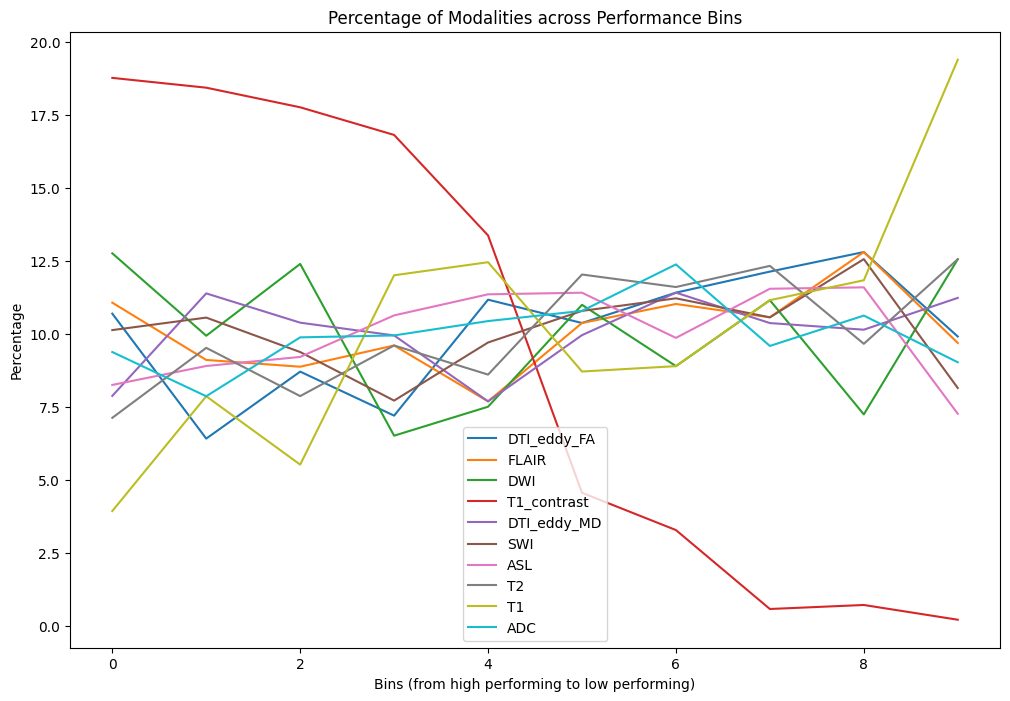

In [76]:
# Define the number of bins
num_bins = 10

# Create bins based on 'sum' column
df_sorted_all['bin'] = pd.qcut(df_sorted_all['sum'], q=num_bins, labels=False, duplicates='drop')

# Initialize an empty dictionary to store the results
results = {}

# Iterate over each bin
for bin_num in range(num_bins):
    # Get rows corresponding to the current bin
    bin_rows = df_sorted_all[df_sorted_all['bin'] == bin_num]

    # Convert string to tuple and flatten the list of acquisitions
    all_acquisitions = [acquisition for sublist in bin_rows['Acquisition'].apply(ast.literal_eval) for acquisition in sublist]

    # Count the frequency of each acquisition
    counter = Counter(all_acquisitions)

    # Store the counter in the results dictionary
    results[bin_num] = counter

# List of all modalities
all_modalities = ['DTI_eddy_FA', 'FLAIR', 'DWI', 'T1_contrast', 'DTI_eddy_MD', 'SWI', 'ASL', 'T2', 'T1','ADC']

# Initialize a dictionary to hold counts for each modality and for the average
modality_counts = {modality: [] for modality in all_modalities}
average_acquisitions = []

# Populate the counts from the results dictionary
for bin_num in range(num_bins-1, -1, -1):  # iterating in reverse order
    # Skip the bin if there are no entries in it
    if len(results[bin_num]) == 0:
        continue

    # Count the total acquisitions
    total_acquisitions = sum(results[bin_num].values())
    
    # Count each modality and compute its percentage
    for modality in all_modalities:
        modality_counts[modality].append((results[bin_num][modality] / total_acquisitions) * 100)

# Plotting
plt.figure(figsize=(12,8))
for modality, counts in modality_counts.items():
    plt.plot(range(len(counts)), counts, label=modality)

plt.xlabel('Bins (from high performing to low performing)')
plt.ylabel('Percentage')
plt.legend()
plt.title('Percentage of Modalities across Performance Bins')
plt.show()

## Average performance if Modality present

In [72]:
# List of all modalities
all_modalities = ['DTI_eddy_FA', 'FLAIR', 'DWI', 'T1_contrast', 'DTI_eddy_MD', 'SWI', 'ASL', 'T2']

# Initialize dictionaries to hold totals and counts for each modality
modality_totals = {modality: 0 for modality in all_modalities}
modality_counts = {modality: 0 for modality in all_modalities}

# Iterate over each row of the DataFrame
for index, row in df_sorted_all.iterrows():
    # Convert string to tuple
    acquisitions = ast.literal_eval(row['Acquisition'])
    
    # For each modality
    for modality in all_modalities:
        # If modality is present in the acquisitions
        if modality in acquisitions:
            # Add the sum to the total and increment the count
            modality_totals[modality] += row['sum']
            modality_counts[modality] += 1

# Calculate the average performance for each modality
modality_averages = {modality: total / count if count > 0 else 0 
                     for modality, total, count in zip(modality_totals.keys(), 
                                                       modality_totals.values(), 
                                                       modality_counts.values())}

# Sort modality_averages dictionary by values in descending order
sorted_averages = dict(sorted(modality_averages.items(), key=lambda item: item[1], reverse=True))

# Print each modality and its average, rounded to two decimal places
for modality, average in sorted_averages.items():
    print(f"{modality}: {average:.2f}")

T1_contrast: 1.51
DWI: 1.43
SWI: 1.43
FLAIR: 1.42
ASL: 1.42
DTI_eddy_MD: 1.42
DTI_eddy_FA: 1.42
T2: 1.41
